# Part 1: Stacking with sklearn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import sem
from numpy.random import permutation

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

### Wine quality prediction

We will use a dataset of wines, with their attributes and quality. The goal is to predict the quality from the given attributes for unseen data.

In [3]:
data = pd.read_csv("wine_quality.csv")

Inspect the dataset with `.head()`.

In [4]:
# Your code here...
data.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Create an input data array `X` (with all columns except quality), and the output array `y`. Set the output array to `float64` type.

In [5]:
# Your code here...
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed.acidity         6497 non-null   float64
 1   volatile.acidity      6497 non-null   float64
 2   citric.acid           6497 non-null   float64
 3   residual.sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free.sulfur.dioxide   6497 non-null   float64
 6   total.sulfur.dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 609.2 KB


In [48]:
X = np.array(data.copy().drop(columns = 'quality'))
y = np.array(data['quality'], dtype = np.float64)

Print how many rows and columns your input array contains.

In [49]:
# Your code here...
print('X: ',X.shape)
print('y: ',y.shape)


X:  (6497, 11)
y:  (6497,)


Divide your input data into 5-fold cross-validation sets, using the `KFold` method. Assign it to the variable `cv`.

Use randomized splits by setting the `shuffle` attribute to `True`. This is required since our data has not been randomized and is in fact ordered by wine type (reds and whites). Not randomizing the splits would make different sample distributions for the training and test sets.

In [50]:
# Your code here...
from sklearn.model_selection import KFold
cv = KFold(5, shuffle= True)

### Training multiple classifiers

Let's start by training different kinds of classifiers, which we will bundle together later.

Train a Linear Regression model by iterating over the 5-fold data split you created, fitting a model to the training data, and calculating the prediction error for the test data. Use the `mean_squared_error()` metric. 

Save the final scores to `scores_linreg` and print it.

In [51]:
scores_linreg = []
for train_index, test_index in cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model_linreg = LinearRegression()
    model_linreg.fit(X_train, y_train)

    y_pred = model_linreg.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)

    scores_linreg.append(mse)
scores_linreg

[0.5441259754643766,
 0.5074475721147101,
 0.5615923934938936,
 0.5507567044983434,
 0.5509029442240492]

Now let us train a Support Vector Regression (`SVR`) model. This time use the convenience method `cross_val_score()` that implements the cross-validation and scoring procedure. Set the `scoring` attribute to `"neg_mean_squared_error"`.

Save the final scores to `scores_svr` and print it.

In [52]:
# Your code here...
from sklearn.model_selection import cross_val_score
model_svr = SVR()
scores_svr = cross_val_score(model_svr, X, y, scoring = 'neg_mean_squared_error', cv = cv)

In [53]:
scores_svr

array([-0.70315997, -0.57443975, -0.62009033, -0.62142217, -0.69203309])

As a third model, train a `DecisionTreeRegressor`, again using the `cross_val_score()`. 

Save the final scores to `scores_dtr` and print it.

In [54]:
# Your code here...
from sklearn.tree import DecisionTreeRegressor
model_dtr = DecisionTreeRegressor()
scores_dtr = cross_val_score(model_dtr, X, y, cv = cv, scoring='neg_mean_squared_error')

In [55]:
scores_dtr

array([-0.71461538, -0.69153846, -0.64203233, -0.75134719, -0.75211701])

### Creating a Stacking ensemble

The Stacking method takes individual prediction models and combines their predictions through an additional model.

Create a Stacking model with `StackingRegressor()` that combines the three types of models we have used (Linear Regression, SVR and Decision Tree Regressor) and uses a Linear Regression model as the final layer. 

Set it up with a 6-fold cross-validation split. Note that this is the level-2 cross-validation split, which is different to the cross-validation of the dataset done at the start.

Fit and score the model with `cross_val_score()`. Save the scores to `score_stack` and print it.

In [56]:
# Your code here...
from sklearn.ensemble import StackingRegressor
stack_linreg = LinearRegression()

model_stack = StackingRegressor(
    [
    ('linreg', LinearRegression()),
    ('svc', SVR()),
    ('dtr', DecisionTreeRegressor())
    ],
    final_estimator=stack_linreg,
    cv = 6)

score_stack = cross_val_score(model_stack, X, y, scoring = 'neg_mean_squared_error', cv=cv)

score_stack

array([-0.49995522, -0.48875842, -0.48810057, -0.50446217, -0.51606935])

Print the average score of each for the four approaches. Note that the sign of the score may be inverted depending on the scoring method used.

Which model has the smallest test error?

In [58]:
# Your code here...
np.mean(scores_linreg), np.mean(scores_svr), np.mean(scores_dtr), np.mean(score_stack)


(0.5429651179590745,
 -0.6422290628653297,
 -0.7103300763901226,
 -0.4994691434826379)

Create a bar plot to visualize the resulting scores, with `plt.bar()`.

Calculate the standard error of the mean with `sem()` and use it for the `yerr` parameter.

Name each bar with the model label.

Set the vertical axis lower limit with `ylim(0.4)`.

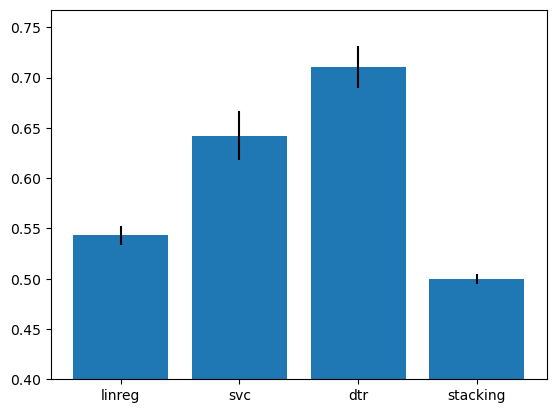

In [59]:
# Your code here...
scores = np.array([scores_linreg, -scores_svr, -scores_dtr, -score_stack])
labels = ["linreg", "svc", "dtr", "stacking"]

plt.bar(range(4), scores.mean(axis=1), yerr=sem(scores.T))
plt.xticks(range(4), labels)
plt.ylim(0.4)
plt.show()


The Stacking model combined the predictions of the individual models. As some models give better predictions than others, this should be reflected in how the stacking model weights each of them.

To inspect this, create a Stacking model as above (or reuse it) and now fit it to the whole dataset `X`. 

Print the final coefficients of the meta-learner layer, stored under `.final_estimator_.coef_`. Which model is given more weight and why?

In [60]:
# Your code here...
stack = model_stack.fit(X, y)
stack.final_estimator_.coef_

array([0.6622386 , 0.46730228, 0.10658763])

# Part 2: Blending implementation

Blending is a simplified version of Stacking. Instead of using K-fold cross-validation, it uses one single split of the training data: one for the individual models, one for the meta-learner.

Here we will implement this ensemble method for the same data and prediction models as in Part 1. 

### Level-1 Blending model

Let us start by implementing only level-1 (without level-2 cross-validation).

Divide the dataset `X` and `y` into training and validation sets (`X_train`, `y_train`, `X_val`, `y_val`), with 500 samples.

You may use `permutation()` to shuffle your data samples.

In [62]:
# Your code here...
inds = permutation(len(X)) #this creates the funtion which is called upon later
X_train, y_train = X[inds[:-500]], y[inds[:-500]]
X_val, y_val = X[inds[-500:]], y[inds[-500:]]

Create the three individual prediction models, as in Part 1, and fit them to the training set.

In [63]:
# Your code here...
model_linreg = LinearRegression().fit(X_train, y_train)
model_svr = SVR().fit(X_train, y_train)
model_dtr = DecisionTreeRegressor().fit(X_train, y_train)


Stack their predictions for the validation set into a into a single array.

In [68]:
# Your code here...
stacked_output = np.array(
    [
        model_linreg.predict(X_val),
        model_svr.predict(X_val), 
        model_dtr.predict(X_val)
    ]
).T

In [69]:
stacked_output

array([[6.3926141 , 6.17420513, 6.        ],
       [6.24183634, 6.16753254, 7.        ],
       [6.07559448, 5.85277184, 6.        ],
       ...,
       [5.64051409, 5.70989173, 4.        ],
       [6.59183884, 6.3690959 , 6.        ],
       [5.87066414, 5.89153768, 6.        ]])

Create a Linear Regression meta-learner and fit it to the validation set.

In [70]:
# Your code here...
meta_learner = LinearRegression().fit(stacked_output, y_val)

Create a function that implements the Blending prediction, by combining the prediction of the individual models and the meta-learner.

In [71]:
# Your code here...
blending = lambda x: meta_learner.predict(np.array(
    [
        model_linreg.predict(x), 
        model_svr.predict(x),
        model_dtr.predict(x)
    ]
).T)

In [72]:
blending

<function __main__.<lambda>(x)>

Check the error of the Blending model to the data `X`. 

Note that this is the training error, not the test error, of our Blending model, as we did not do level-2 cross-validation yet, and it will be lower than the test error.

In [73]:
# Your code here...
mean_squared_error(y, blending(X))

0.20404105920200577

Combine the previous steps into a function named `train_blending(X_train, y_train, X_val, y_val)`, that takes a split dataset and returns the Blending model. 

In [74]:
# Your code here...
def train_blending(X_train, y_train, X_val, y_val):
    model_linreg = LinearRegression().fit(X_train, y_train)
    model_svr = SVR().fit(X_train, y_train)
    model_dtr = DecisionTreeRegressor().fit(X_train, y_train)
    
    blending = lambda x: meta_learner.predict(np.array(
        [
            model_linreg.predict(x), 
            model_svr.predict(x),
            model_dtr.predict(x)
        ]
    ).T)
    
    return blending

In [ ]:
# alternative 

def blending_2(x):

    # predictions for new data

    pred_linreg = model_linreg.predict(x)

    pred_svr = model_svr.predict(x)

    pred_dtr = model_dtr.predict(x)
 
    # Stacking the predictions for meta-learner

    stacked_predictions = np.column_stack((pred_linreg, pred_svr, pred_dtr))
 
    # Return predictions from meta-learner

    return meta_learner.predict(stacked_predictions)

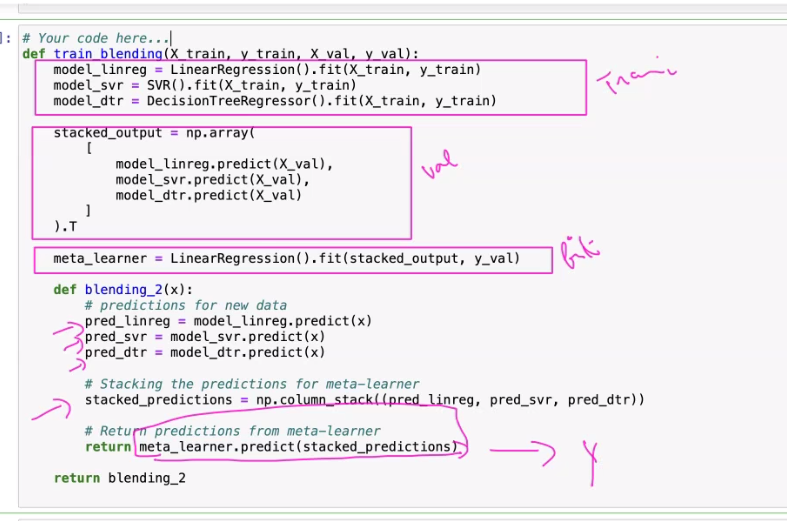

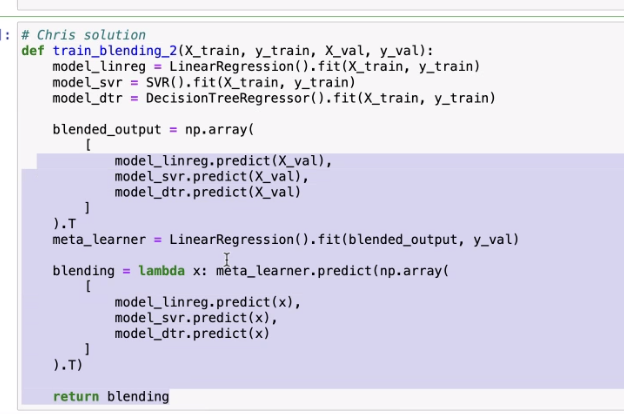

In [ ]:
# alternative 
def blending_2(x):
    # predictions for new data
    pred_linreg = model_linreg.predict(x)
    pred_svr = model_svr.predict(x)
    pred_dtr = model_dtr.predict(x)
 
    # Stacking the predictions for meta-learner
    stacked_predictions = np.column_stack((pred_linreg, pred_svr, pred_dtr))
 
    # Return predictions from meta-learner
    return meta_learner.predict(stacked_predictions)

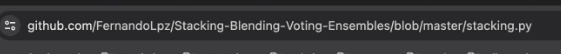

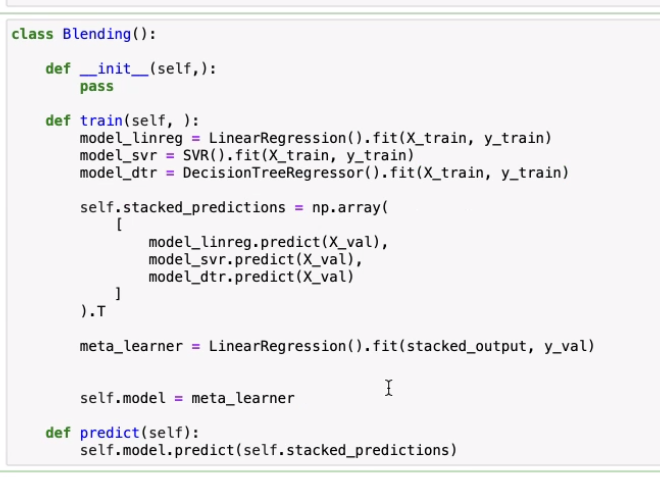




### Level-2 cross-validation

Now we will do things properly and first divide the dataset in a level-2 cross-validation split.

Create a 5-Fold randomized split of the dataset with `KFold()`. Iterate over the splits, each time creating the Blending model with `train_blending()` and the training set, and saving the error for the test set. Print the average error and compare with the models in Part 1.

In [76]:
# Your code here...
cv1 = 5
val_size = 500

splits = KFold(n_splits=cv1, shuffle=True).split(X)

scores = []
for train_index, test_index in splits:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = train_blending(
        X_train[:-val_size],
        y_train[:-val_size],
        X_train[-val_size:],
        y_train[-val_size:]
    )
    scores += [mean_squared_error(y_test, model(X_test))]
    
score_blending = np.mean(scores)
print(score_blending)


0.4808471386556132
